# Homework 3

Write your own Metropolis Hastings (and Gibbs) sampler. Feel free to use some of the code above:
* Choose a bivariate normal (Gaussian) distribution as the likelihood of the 2-dimensional data vector $p(D|\theta_1, \theta_2)$

$$p(D|\theta_1, \theta_2) \propto \exp \biggl( -\frac{1}{2} \underbrace{\left[ (D-M)^t \, C^{-1} \, (D-M) \right]}_{\chi^2(\theta_1, \theta_2)}  \biggr) $$
* Assume $\theta_1$ ranges from 0.1-0.5, and $\theta_2$ ranges from 0.6-1.0. The true values are $\theta_1=0.3$ and $\theta_2=0.8$
* Assume a simple mapping of the underlying parameters $\theta_1$, $\theta_2$ onto the data vector $D=(d_1,d_2)$, e.g. the simplest mapping is $d_1=\theta_1$ and $d_2=\theta_2$. Please use something slightly more complex. Note that usually the mapping of underlying parameters onto data is a complex function involving ODEs, PDEs, intergrals, interpolation routines, differentiation, etc. More importantly, each data point is usually a function of several, sometimes of all underlying parameters; there is not a 1-1 mapping of a parameter onto 1 data point (although there are transformations on the data vector that can achieve this).
* Define a conjugate, uninfromative prior (uninformative under the assumption that parameters enter linearly). Later choose more informative priors.
* Define a (co)variance matrix in data space, and play with the values of $N$ and $\rho$ (you can set both to zero at first)
$$
\begin{bmatrix}
d_1^2+N & \rho\\
\rho & d_2^2+N
\end{bmatrix}
$$

* With all this information, generate a data vector $D$ at the true values $\theta_1$ and $\theta_2$ and then sample $\theta_1$ and $\theta_2$ (using your model definition and your covariance matrix) based on a Metropolis Hastings (and Gibbs) to estimate the posterior probability.

* Repeat the above with different priors, different values for $N$ and $\rho$ in the covariance, explain what you see. Feel free to go to higher dimensions in both data and parameter space.

# Metropolis-Hastings Sampling

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import scipy.stats as st
import corner
# BP Necessary imports.

First we create some model that links our data space and parameter space. For the sake of this example this is a fabricated relation, however this is typically where all of the physics and astrophysics is stored. This could be a stellar model that takes in mass, gravity, and metallicity and provides an SED, or a model that gives protoplanetary mass from disk parameters.

In [2]:
def model(thetas):
    '''
    Mapping of underlying parameters onto data vector.
    '''
    d_1 = thetas[0] - thetas[1]**2
    d_2 = np.log(thetas[1])
    # BP Defining arbitrary non-linear model.
    
    return np.array([d_1, d_2])

Now we create our priors. This contains all previous knowledge on the values of the parameters. For our initial run, we assume no prior knowledge and adopt a uniform prior on a set interval for each parameter. These limits could have some physical motivation.

In [3]:
def uniform_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        return 1
    # BP Defining uninformative (uniform) priors from 0.1-0.5 and 0.6-1.0.

Typically, the most difficult part of Bayesian analysis is defining our likelihood. This describes how likely it is that our given model, typically supplied by the sampler, would result in the data values seen. We choose to calculate this as a multivariate Gaussian, although there are many choices for this function.

In [4]:
def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

We now lay out the Metropolis-Hastings sampling method. The basics of the algorithm is as follows:

1. Select some starting point $p$ sampled from the prior distribution.
2. Calculate the target distribution at this point, which is $likelihood \times prior$.
3. Choose a new proposed value $p'$ such that $p' = p + \Delta p$ where $\Delta p$ is sampled from a proposal distribution. We choose for this to be a Gaussian with mean 0.
4. Calculate the target distribution at this new proposed point.
5. Calculate the ratio of the target distributions $\rho$.
6. Accept the new proposed point if $\rho > 1$.
7. Otherwise, draw from a uniform distribution on $[0,1)$ and accept the point if $rho > u$, otherwise reject the point.
8. After repeating for $k$ steps, the target distribution will approach a scaled version of the true posterior.

In [5]:
def mcmc_mh(n, theta0, sigma, target_fn):
    '''
    Primary loop to calculate posterior (target) distribution for a given prior and likelihood using the Metropolis-Hastings MCMC algorithm.
    '''
    samples = np.zeros([n, np.size(theta0)])
    n_accept = 0
    thetas = theta0
    # BP Looping over all iterations
    for i in range(n):
        target = target_fn(thetas)
        # BP Calculating target distribution for current point.
        
        #thetas_prime = st.multivariate_normal(mean = thetas, cov = np.diag([sigma**2])).rvs()
        thetas_prime = thetas + rand.normal(0, sigma, size = len(theta0))
        # BP Calculating new point as small perturbation from current point by sampling a Gaussian with width sigma and mean zero.
        target_prime = target_fn(thetas_prime)
        # BP Calculating target distribution for new point.
        
        rho = min(target_prime / target, 1)
        # BP Calculating likelihood ratio of new point to old point.
        
        u = rand.uniform()
        # BP Sampling from random distribution.
                        
        # BP Checking if ratio is less than the random uniform sample, which is only true when the ratio is less than 1.
        if u < rho:
            n_accept += 1
            thetas = thetas_prime
            # BP Accepting new point as a point in the chain if it is better than the current point (rho > 1) or if it is randomly selected (rho > u).
        else:
            pass
            # BP Rejecting point if it is not selected (rho < u).
        samples[i] = thetas
        # BP Setting next point in the chain.
        
    print("Finished {} steps with an efficiency of {:.2f}%".format(n, n_accept/n*100))
    
    return samples

We now define the specifics of our problem, including the data, covariance matrix, number of steps, step size, and starting point.

In [6]:
data = model([0.3, 0.8])
# BP Defining data from model based on exact parameters.

N = 0
# BP Defining noise.
p = 0
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

n = 100
# BP Defining number of steps.
sigma = 0.1
# BP Defining width of proposal distribution.
theta0 = [0.2, 0.9]
# BP Defining starting parameters.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return uniform_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

All that is left is to now run the MH Sampler and plot the results.

Finished 100 steps with an efficiency of 62.00%


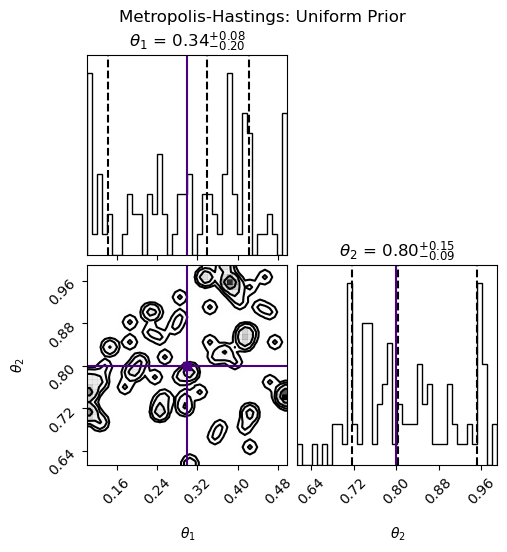

In [7]:
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.
figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

We clearly have not sampled enough of the parameter space. Let us increase the number of steps.

Finished 100000 steps with an efficiency of 58.92%


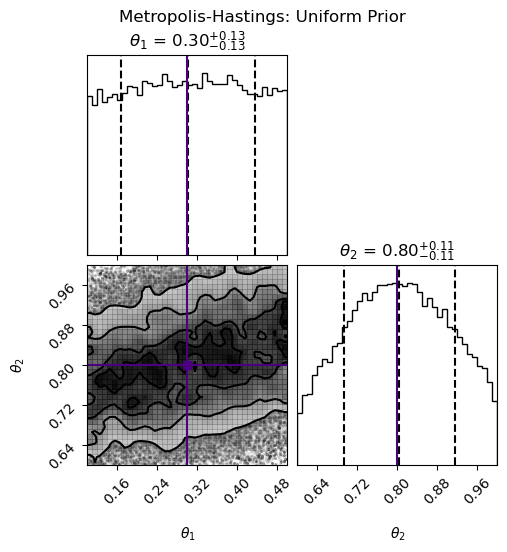

In [8]:
n = 100000
# BP Defining the number of steps.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

This looks much better. From this result, we can tell that the parameters are fairly well sampled, however we do not have enough statistical power in our experiment to determine $\theta_1$ accurately. Using a uniform prior, we are essentially just sampling from the likelihood itself, which is driven by the data. We are in the data dominated domain range, and with only 2 data points we have very little information on the parameters.

We can also elect to change our step size or our starting values. Changing the starting value will have little effect on unimodal distributions like this, assuming we converge. Changing the step size, however, can have drastic effects.

/tmp/ipykernel_903867/2547868921.py:6: RuntimeWarning: invalid value encountered in log
  d_2 = np.log(thetas[1])


Finished 100000 steps with an efficiency of 2.03%


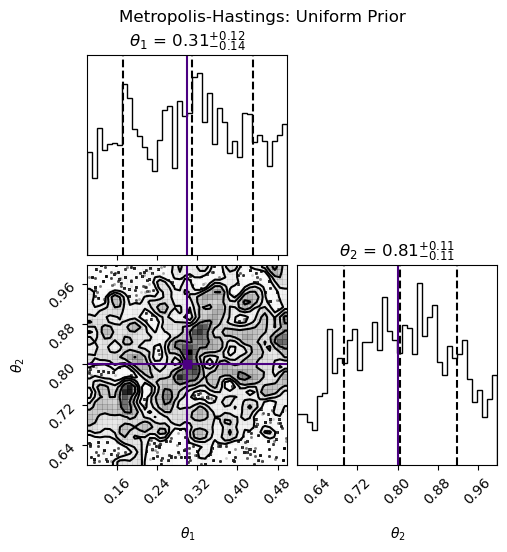

In [9]:
sigma = 1
# BP Defining the step size.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

While this appears to be converging the same as the last run, there are clearly many fewer samples, which is echoed by the low acceptance rate. We must also be careful to avoid step sizes that are too small and will not sample all of parameter space efficiently.

Finished 100000 steps with an efficiency of 99.67%


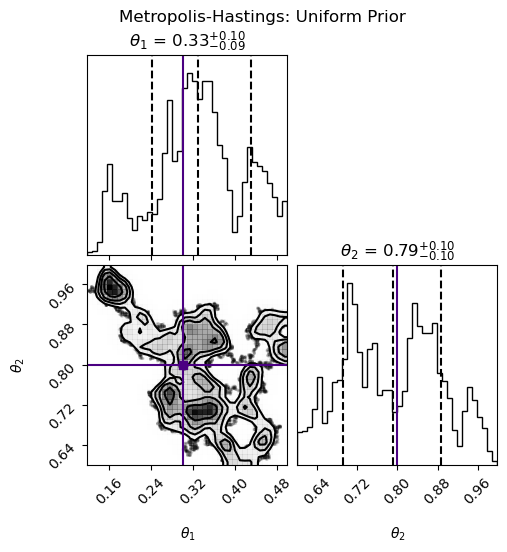

In [10]:
sigma = 0.001
# BP Defining the step size.
samples = mcmc_mh(n, theta0, sigma, target)
# BP Running the MCMC.

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 40,
    truth_color = 'indigo',
    )
_ = figure.suptitle('Metropolis-Hastings: Uniform Prior', y = 1.01)

While nearly all of the steps were accepted, it is clear not all of parameter space was effectively explored. A delicate balance must be made between the number of steps and the step size. This is further evidenced by the chain, which does not converge.

Text(0.5, 1.0, 'Metropolis-Hastings Chain')

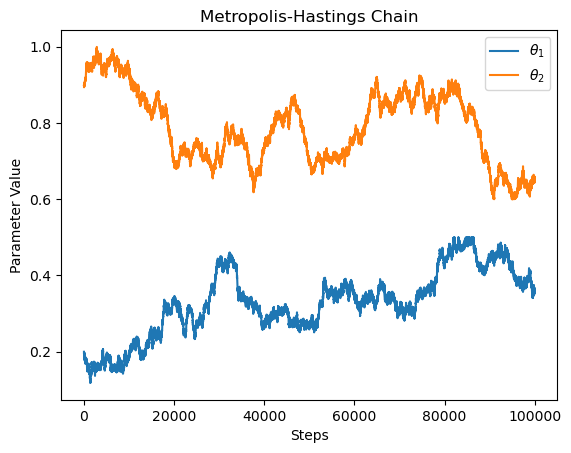

In [11]:
plt.plot(samples[:, 0], label=r'$\theta_1$')
plt.plot(samples[:, 1], label=r'$\theta_2$')
plt.xlabel('Steps')
plt.ylabel('Parameter Value')
plt.legend(loc = 'best')
plt.title('Metropolis-Hastings Chain')

## Gaussian Prior

Alternatively, we can run the same analysis with more informative Gaussian priors with tight widths.

In [12]:
def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.8], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

We then redefine our target distribution using this updated prior.

In [13]:
def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

We can then rerun the analysis with the new prior function.

Finished 10000 steps with an efficiency of 48.89%


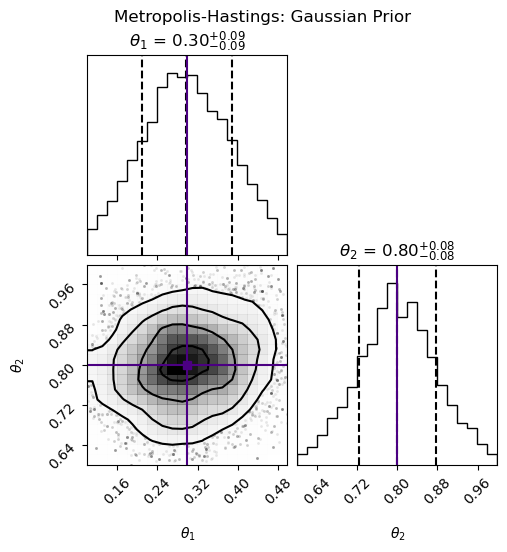

In [14]:
n = 10000
# BP Defining number of steps.
sigma = 0.1
# BP Defining step size.

samples = mcmc_mh(n, theta0, sigma, target)
# BP Running MCMC.
figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 20,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

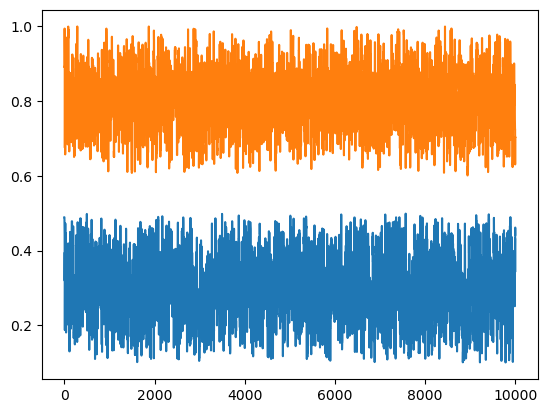

In [15]:
plt.plot(samples)

We now, clearly, have much more constrained results for our parameters. In fact, most of this constraint comes from the priors themselves, rather than from the data.

Perhaps now we assume that our predicted value for both parameters is different than the truth. We once again can define a new prior and likelihood.

In [16]:
def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.45, 0.75], cov = [[0.001, 0], [0, 0.001]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

We then redefine our target distribution using this updated prior.

In [17]:
def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

We can then rerun the analysis with the new prior function.

Finished 10000 steps with an efficiency of 13.73%


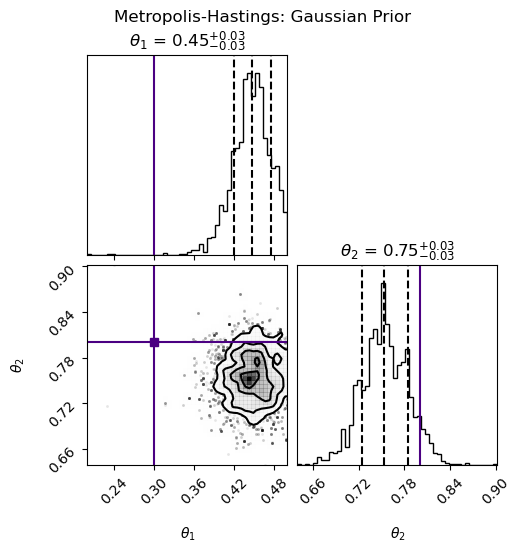

In [18]:
samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

With such strong priors, the posterior is very strongly influenced.

## Covariance Dependence

Alternatively, we can investigate how the posterior changes as we modify the covariance matrix. Earlier we had assumed no noise and no correlation ($N = 0$,$\rho = 0). By introducing noise, we can expect the overall constraint of our experiment to decrease. We assume a very tight Gaussian prior. First we run the analysis with no assumed noise.

In [19]:
def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.7], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

In [20]:
N = 0
# BP Defining noise.
p = 0
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

n = 100000
# BP Defining number of steps.
sigma = 0.1
# BP Defining width of proposal distribution.
theta0 = [0.2, 0.9]
# BP Defining starting parameters.

We can then update our likelihood and target distribution functions.

In [21]:
def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

Finished 100000 steps with an efficiency of 47.05%


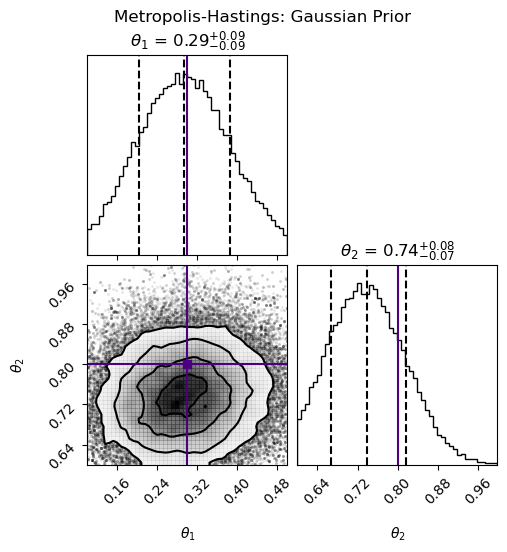

In [22]:
samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

Now let us add noise into the covariance matrix and run it again.

Finished 100000 steps with an efficiency of 48.59%


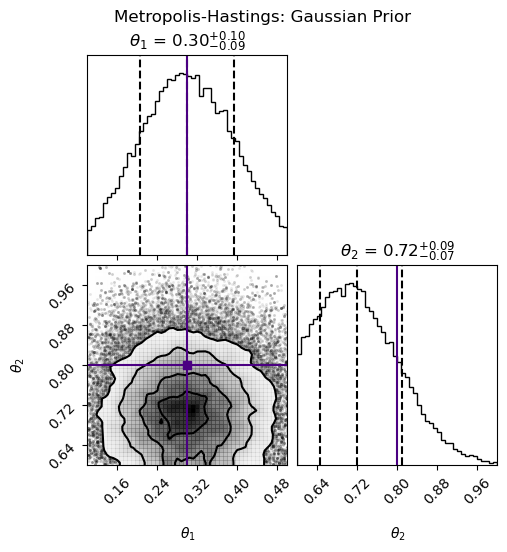

In [23]:
N = 10000000000000
# BP Defining noise.
p = 0
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.7], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

As before, our data has very little constraining power over the posterior because we have so few data points. With a more complicated model, we would expect to see it shift from the data dominated regime into the prior dominated regime. We can remedy this by artifically increasing the constraining power of the data by shrinking the diagonal elements of the covariance matrix.

Finished 100000 steps with an efficiency of 13.21%


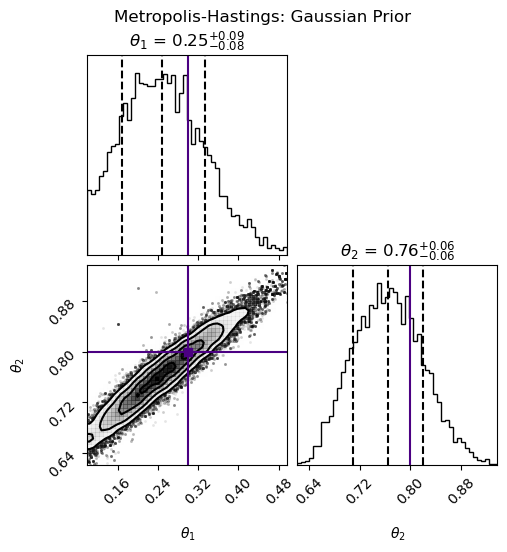

In [24]:
N = -0.115
# BP Defining noise.
p = 0
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.7], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

Now we can see a very tight correlation between the parameters, which is given by our model (remember the first data point relied on both parameters). We can now begin to introduce covariances along the diagonals.

Finished 100000 steps with an efficiency of 38.66%


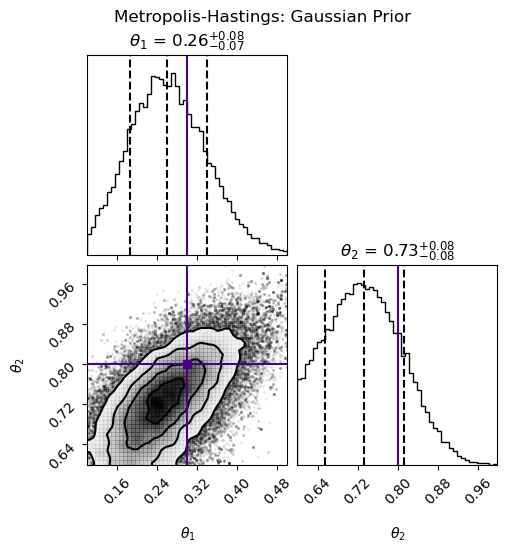

In [25]:
N = -0.115
# BP Defining noise.
p = 0.02
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [p, data[1]**2 + N]])
# BP Defining covariance matrix.

def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.7], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

Because we are tellling the likelihood function that the parameters are correlated, the resulting posterior distribution no longer has as much constraining power, and we move back into a prior dominated regime. We can also make the covariance matrix non-symmetric, and we would expect the posterior to become distorted.

Finished 100000 steps with an efficiency of 6.69%


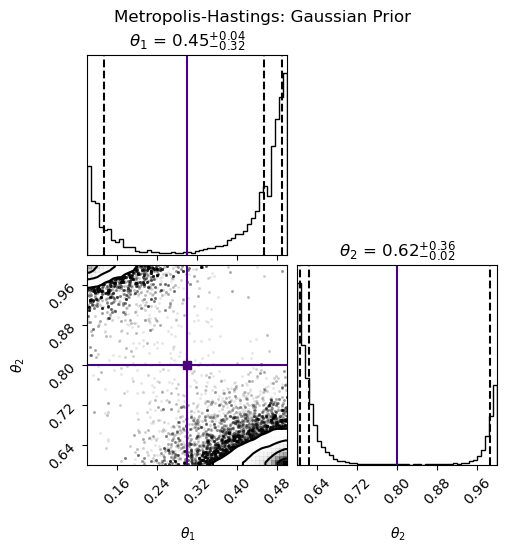

In [26]:
N = -0.115
# BP Defining noise.
p = 0.02
# BP Defining off-axis covariance elements.

covariance = np.array([[data[0]**2 + N, p],
                       [-p*2, data[1]**2 + N]])
# BP Defining covariance matrix.

def likelihood(thetas, data, covariance):
    '''
    Probability that given values for parameters in the model would produce observed data.
    Defined using a bivariate Gaussian.
    '''
    chi_sq = (data - model(thetas)).T @ np.linalg.inv(covariance) @ (data - model(thetas))
    # BP Calculating chi squared function in power of exponential.
    L = np.exp(-0.5 * chi_sq)
    # BP Evaluating full likelihood.
    return L

def gauss_prior(thetas):
    '''
    Prior distribution defining propability of parameters being a given value.
    '''
    if (thetas[0] < 0.1) | (thetas[0] > 0.5):
        return 0
    elif (thetas[1] < 0.6) | (thetas[1] > 1.0):
        return 0
    else:
        #return 1
        return st.multivariate_normal.pdf(thetas, mean = [0.3, 0.7], cov = [[0.01, 0], [0, 0.01]])
    # BP Defining gaussian priors from 0.1-0.5 and 0.6-1.0 centered at 0.3 and 0.8.

def target(thetas):
    '''
    Target distribution as a function of purely parameters. Uses already defined prior, likelihood, data, and covariance.
    '''
    return gauss_prior(thetas) * likelihood(thetas, data, covariance)
# BP Defining target distribution using already specified variables.

samples = mcmc_mh(n, theta0, sigma, target)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gaussian Prior', y = 1.01)

This clearly introduces complicated correlations and relationships that are likely too complicated to describe with an analytical model to produce the covariance matrix. This also emphasizes the need for an accurate covariance matrix, as small shifts and non-symmetry drastically affect the results.

# Gibbs Sampling

In Gibbs Sampling, we have to assume that we know the conditional (posterior) probabilities for each parameter. In essence, we are using the 1D posteriors to calculate the full ND (in this case 2D) posterior. Thus, we assume each parameter follows a Gaussian conditional centered at the true values with moderate variances.

In [27]:
def conditional1():
    '''
    Conditional posterior centered at known 'mean' with known 'variance' for the first parameter.
    '''
    res = np.inf
    while ((res < 0.1) | (res > 0.5)):
        res = st.norm(loc = 0.3, scale = 0.05).rvs()
    return res
    
def conditional2():    
    '''
    Conditional posterior centered at known 'mean' with known 'variance' for the second parameter.
    '''
    res = np.inf
    while ((res < 0.5) | (res > 1.0)):
        res = st.norm(loc = 0.8, scale = 0.15).rvs()
    return res
    
conditionals = [conditional1, conditional2]
# BP Defining list of conditional posterior distributions for each parameter in thetas.

We can then define our Gibbs Sampling algorithm, which samples each parameter individually from their respective conditional probability. 

In [28]:
def mcmc_gibbs(n, thetas, conditionals):
    '''
    Primary loop to calculate posterior (target) distribution for a given prior and likelihood using a Metropolis-Hasting with Gibbs Sampling MCMC algorithm.
    '''
    samples = np.empty([n, np.size(thetas)])
    n_accept = 0
    # BP Looping over all iterations
    for i in range(n):
        for j in range(len(thetas)):
            thetas[j] =  conditionals[j]()

        samples[i] = thetas
        # BP Setting next point in the chain.
        
    print("Finished {} steps.".format(n))
    
    return samples

All that's left now is define our model and other parameters and to run the sampler.

Finished 100000 steps.


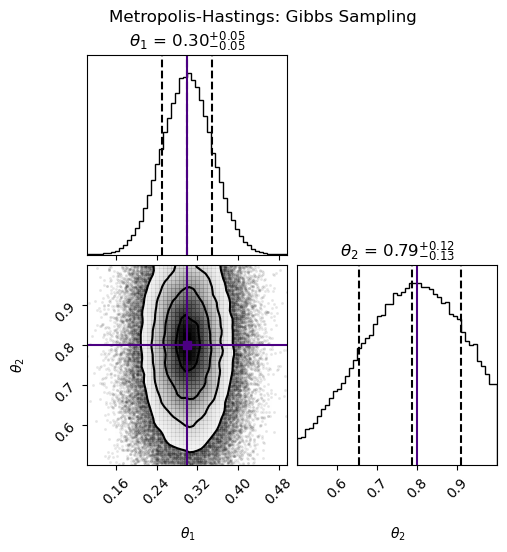

In [29]:
data = model([0.3, 0.8])
# BP Defining data from model based on exact parameters.

n = 100000
# BP Defining number of steps.
theta0 = [0.2, 0.9]
# BP Defining starting parameters.

samples = mcmc_gibbs(n, theta0, conditionals)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gibbs Sampling', y = 1.01)

We of course can change the conditional posteriors to be more or less constraining with slightly different means. Here we assume we don't know the conditional probability for $\theta_2$ that well.

Finished 100000 steps.


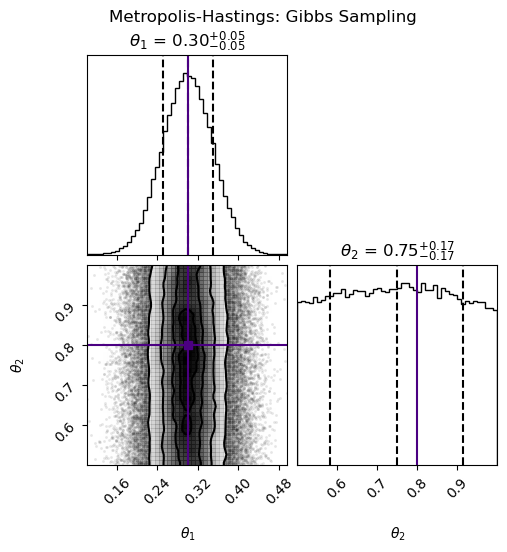

In [30]:
def conditional2():    
    '''
    Conditional posterior centered at known 'mean' with known 'variance' for the second parameter.
    '''
    res = np.inf
    while ((res < 0.5) | (res > 1.0)):
        res = st.norm(loc = 0.75, scale = 0.5).rvs()
    return res
    
conditionals = [conditional1, conditional2]

samples = mcmc_gibbs(n, theta0, conditionals)

figure = corner.corner(samples,
    labels=[
        r"$\theta_1$",
        r"$\theta_2$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    smooth = 1,
    truths = [0.3,0.8],
    bins = 50,
    truth_color = 'indigo'
    )
_ = figure.suptitle('Metropolis-Hastings: Gibbs Sampling', y = 1.01)

Because our conditional probability for $\theta_2$ is so wide, the reported confidence levels are misleading and underestimate the standard deviation. If we truly know that $\theta_2$ must lie within our supplied range, the value we report must reflect this bias.